<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 2
shuffle_buffer_size = 1000

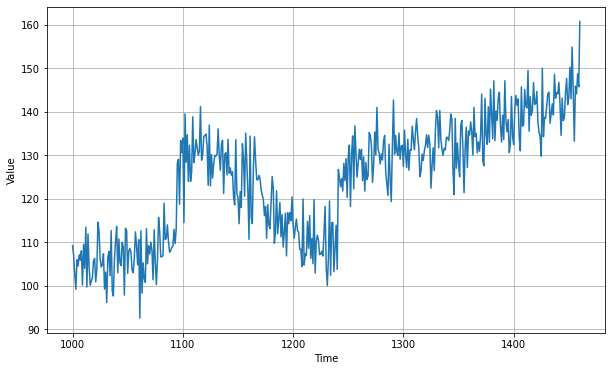

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [29]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
490/490 [==============================] - 1s 1ms/step - loss: 76.2817
Epoch 2/100
490/490 [==============================] - 1s 1ms/step - loss: 61.0046
Epoch 3/100
490/490 [==============================] - 1s 1ms/step - loss: 47.6612
Epoch 4/100
490/490 [==============================] - 1s 1ms/step - loss: 48.0980
Epoch 5/100
490/490 [==============================] - 1s 1ms/step - loss: 47.4232
Epoch 6/100
490/490 [==============================] - 0s 1ms/step - loss: 43.8956
Epoch 7/100
490/490 [==============================] - 1s 1ms/step - loss: 42.9474
Epoch 8/100
490/490 [==============================] - 0s 1ms/step - loss: 45.1926
Epoch 9/100
490/490 [==============================] - 1s 1ms/step - loss: 40.6637
Epoch 10/100
490/490 [==============================] - 1s 1ms/step - loss: 44.1705
Epoch 11/100
490/490 [==============================] - 1s 1ms/step - loss: 37.9425
Epoch 12/100
490/490 [==============================] - 0s 1ms/step - loss: 42.1311
E

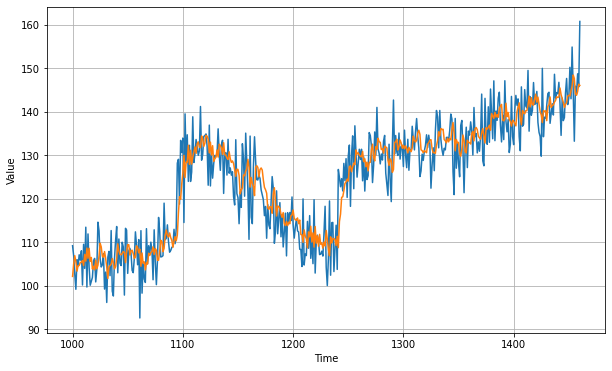

In [30]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5671644

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

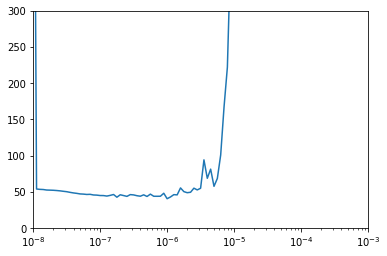

In [33]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [34]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
485/485 [==============================] - 1s 1ms/step - loss: 2789.0596
Epoch 2/500
485/485 [==============================] - 0s 1ms/step - loss: 841.1106
Epoch 3/500
485/485 [==============================] - 0s 1ms/step - loss: 723.3583
Epoch 4/500
485/485 [==============================] - 0s 1ms/step - loss: 722.7252
Epoch 5/500
485/485 [==============================] - 1s 1ms/step - loss: 720.6318
Epoch 6/500
485/485 [==============================] - 1s 1ms/step - loss: 724.5219
Epoch 7/500
485/485 [==============================] - 1s 1ms/step - loss: 722.6235
Epoch 8/500
485/485 [==============================] - 0s 1ms/step - loss: 722.8734
Epoch 9/500
485/485 [==============================] - 0s 1ms/step - loss: 724.0359
Epoch 10/500
485/485 [==============================] - 0s 1000us/step - loss: 723.2093
Epoch 11/500
485/485 [==============================] - 0s 1ms/step - loss: 722.6440
Epoch 12/500
485/485 [==============================] - 0s 994us/step 

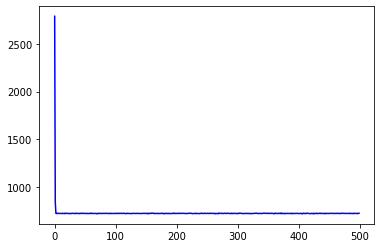

In [35]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[722.6439819335938, 721.0556030273438, 721.5761108398438, 724.1702880859375, 722.9815063476562, 722.2634887695312, 720.0975952148438, 725.4899291992188, 721.3817138671875, 722.250244140625, 724.7493896484375, 723.0844116210938, 721.6153564453125, 723.06591796875, 722.470703125, 720.2455444335938, 719.7946166992188, 723.4850463867188, 722.44091796875, 723.9074096679688, 723.1909790039062, 721.6661987304688, 721.7916870117188, 722.8414306640625, 721.4013061523438, 725.2598876953125, 721.9618530273438, 723.3358154296875, 722.1819458007812, 721.5390014648438, 722.7611694335938, 719.9689331054688, 723.19873046875, 723.437255859375, 721.5849609375, 725.1874389648438, 722.8562622070312, 724.2426147460938, 722.3095703125, 721.267333984375, 722.5401611328125, 722.1705322265625, 723.7236938476562, 720.723388671875, 722.3834228515625, 721.1122436523438, 723.2391967773438, 721.6055297851562, 721.3268432617188, 725.3121337890625, 721.1221923828125, 724.4072265625, 721.5923461914062, 721.45739746093

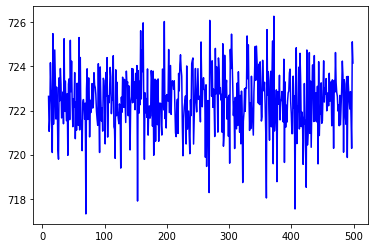

In [36]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

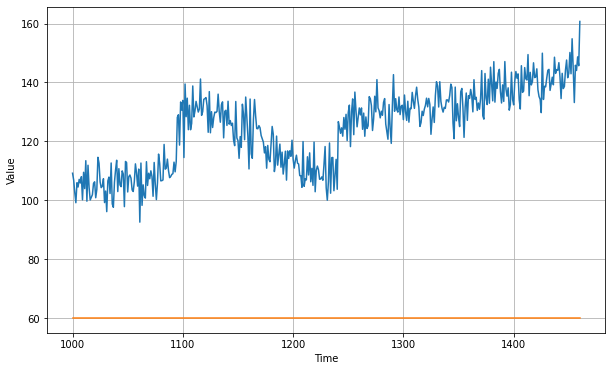

In [37]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

64.389534